In [1]:
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
import os

test_fit = os.path.join('..', 'data', 'glg_tte_n7_bn090926181_v00.fit')

tte = TTE.open(test_fit)
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)

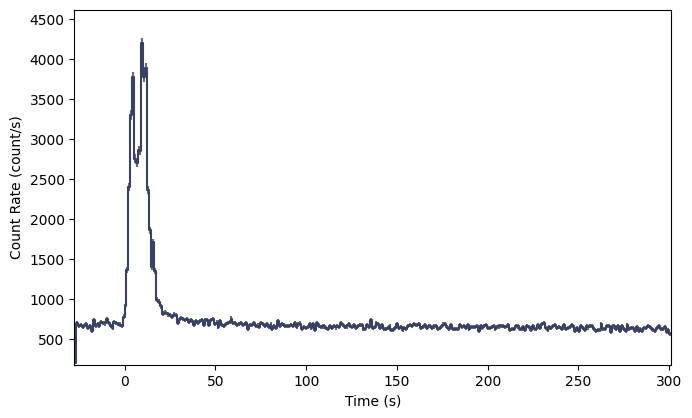

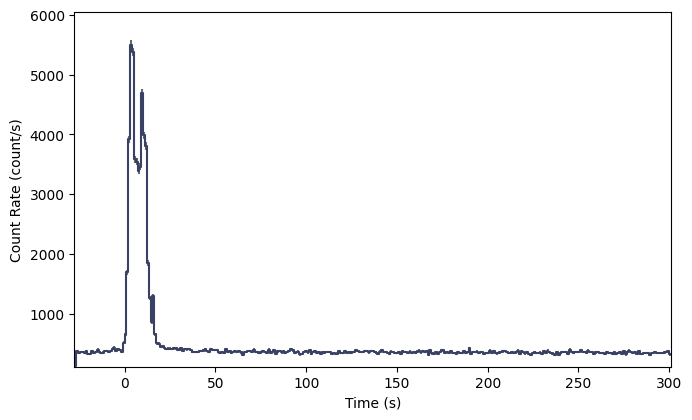

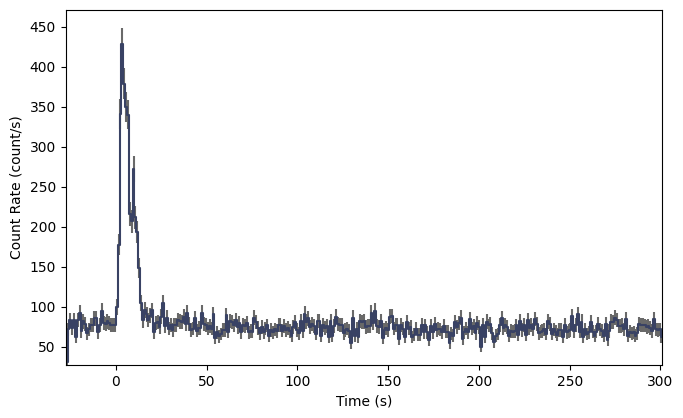

In [2]:
%matplotlib inline
from gbm.plot import Lightcurve

erange1 = (8.0, 50.0)
erange2 = (50.0, 300.0)
erange3 = (300.0, 900.0)

lc_data1 = phaii.to_lightcurve(energy_range=erange1)
lcplot1 = Lightcurve(data=lc_data1)

lc_data2 = phaii.to_lightcurve(energy_range=erange2)
lcplot2 = Lightcurve(data=lc_data2)

lc_data3 = phaii.to_lightcurve(energy_range=erange3)
lcplot3 = Lightcurve(data=lc_data3)

In [3]:
from gbm.data import Cspec, GbmDetectorCollection

test_pha = os.path.join('..', 'data', 'glg_cspec_n7_bn090926181_v00.pha')
n7 = Cspec.open(test_pha)

cspecs = GbmDetectorCollection.from_list([n7])

In [9]:
view_range = (-20.0, 60.0)
bkgd_range = [(-20., -5.), (45., 100.)]
src_range = (10.0, 13.0)
src_range = (14.0, 17.0)

In [5]:
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial

backfitters = [BackgroundFitter.from_phaii(cspec, Polynomial, time_ranges=bkgd_range) for cspec in cspecs]
backfitters = GbmDetectorCollection.from_list(backfitters, dets=cspecs.detector())

backfitters.fit(order=1)

bkgds = backfitters.interpolate_bins(cspecs.data()[0].tstart, cspecs.data()[0].tstop)
bkgds = GbmDetectorCollection.from_list(bkgds, dets=cspecs.detector())

In [6]:
# the lightcurves
data_lcs = cspecs.to_lightcurve(energy_range=erange1)
# the energy-integrated background
bkgd_lcs = bkgds.integrate_energy(*erange1)
# the source time selection
src_lcs = cspecs.to_lightcurve(time_range=src_range, energy_range=erange1)

# the count spectrum
data_specs = cspecs.to_spectrum(time_range=src_range)
# the time-integrated background
bkgd_specs = bkgds.integrate_time(*src_range)
# the energy selection
src_specs = cspecs.to_spectrum(time_range=src_range, energy_range=erange1)

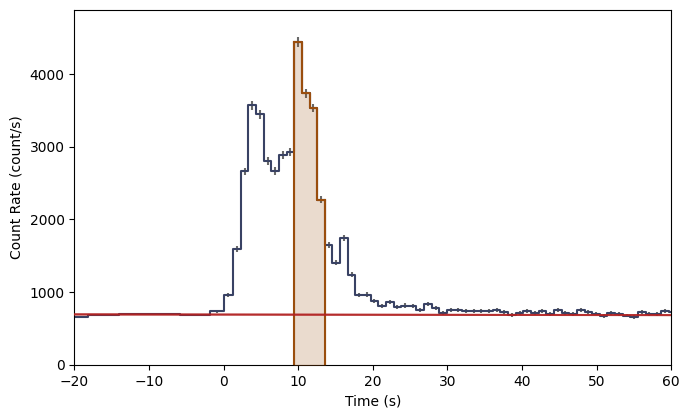

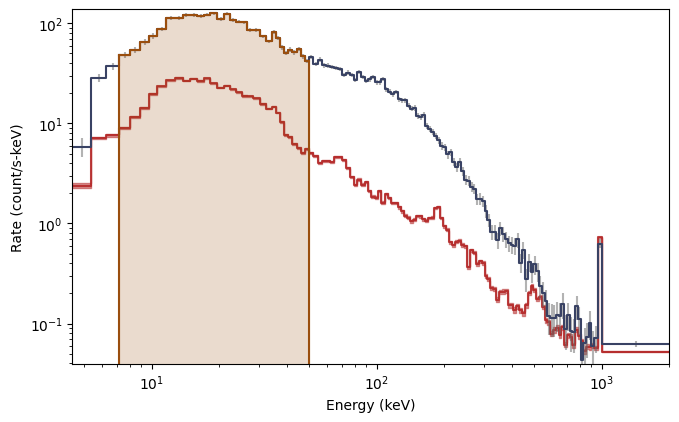

In [10]:
%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

# Plot the lightcurves with the selections and background fit
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]
_ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, src_lcs)]
# zoom in
for lcplot in lcplots:
    lcplot.xlim = view_range
 
# Plot the spectra with the selections and background fit
specplots = [Spectrum(data=data_spec, background=bkgd_spec) for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)]
_ = [specplot.add_selection(src_spec) for specplot, src_spec in zip(specplots, src_specs)]

In [ ]:
src_range = (14.0, 17.0)    # our time selection
erange_nai = (8.0, 900.0) # in keV
erange_bgo = (325, 35000.0)

test_fit2 = os.path.join('..', 'data', 'glg_cspec_n7_bn090926181_v00.rsp2')

from gbm.data import RSP
phas = cspecs.to_pha(time_ranges=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})


test_rps = RSP.open(test_fit2)
rsps = GbmDetectorCollection.from_list([test_rps])

rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]
from gbm.spectra.fitting import SpectralFitterPgstat

# we initialize with our PHAs, backgrounds, and responses:
specfitter = SpectralFitterPgstat(phas, bkgds.to_list(), rsps.to_list(), method='TNC')
from gbm.spectra.functions import PowerLaw, Comptonized, Band

# instantiate a Band function
band = Band()

print('Band Fit:')
specfitter.fit(band, options={'maxiter': 1000})

# After the fit has converged, we can query the fitter for lots of info, including the parameters that
# satisfy the maximum likelihood as well as the parameter uncertainties resulting from -2(Delta)LogLike
print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('90% Asymm. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Band Fit:
Converged (|f_n-f_(n-1)| ~= 0)
Parameters: [ 6.14772561e-02  1.31759602e+02 -1.07230896e+00 -2.65242060e+00]
90% Asymm. Errors:
 [[2.97774553e-03 3.03733166e-03]
 [1.09550291e+01 1.21621948e+01]
 [3.61986786e-02 3.75560522e-02]
 [7.34757940e+00 5.34668886e-01]]
Pgstat/DoF: 70.9844202302208/117


/home/diego/.pyenv/versions/3.6.15/lib/python3.6/site-packages/gbm/spectra/fitting.py:370: UserWarning: Parameter exists at its lower bound
  warnings.warn("Parameter exists at its lower bound")
